# **Tarea 4 - Sequence to Sequence 📚**

**Procesamiento de Lenguaje Natural (CC6205-1 - Otoño 2024)**

## Tarjeta de identificación

**Nombres:** ```Martín Reyes - Sebastián Sanhueza```

**Fecha límite de entrega 📆:** 10/07.

**Tiempo estimado de dedicación:** 4 horas


## Instrucciones

Bienvenid@s a la cuarta tarea en el curso de Natural Language Processing (NLP). Esta tarea tiene como objetivo evaluar los contenidos teóricos de las últimas semanas de clases posteriores a la Tarea 3, enfocado en **Sequence-to-Sequence + Attention**. Si aún no has visto las clases, se recomienda visitar los links de las referencias.

* La tarea es en **grupo** (maximo hasta 3 personas).
* La entrega es a través de u-cursos a más tardar el día estipulado arriba.
* El formato de entrega es este mismo Jupyter Notebook.
* Al momento de la revisión su código será ejecutado. Por favor verifiquen que su entrega no tenga errores de compilación.
* Completar la tarjeta de identificación. Sin ella no podrá tener nota.
* Recomendamos mirar el enunciado completo con atención (*ba dum tss*) antes de empezar la tarea, para tener una idea más completa de lo que se pide.

## Material de referencia

Diapositivas del curso 📄
    
- [Sequence-to-Sequence + Attention](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-seq2seq.pdf)
- [Transformer](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-transformer.pdf)

Videos del curso 📺

- [Sequence-to-Sequence + Attention](https://www.youtube.com/watch?v=OpKxRjISqmM&list=PLppKo85eGXiXIh54H_qz48yHPHeNVJqBi&index=35)
- [Transformer](https://www.youtube.com/watch?v=8RE23Uq8rU0)

## Parte 1: Traducción automática con arquitectura Encoder-Decoder con RNNs
En esta sección crearemos nuestro propio traductor de español a inglés con la arquitecura Encoder-Decoder con RNNs + Attention vista en clases.

In [ ]:
## Importamos librerías

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

### P0. Preparación del dataset y tokenización

Utilizaremos un dataset de pares de oraciones en inglés y castellano.

In [ ]:
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2024-07-07 02:10:30--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  29.4MB/s    in 0.2s    

2024-07-07 02:10:30 (29.4 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


Vamos a crear una clase que nos permita procesar mejor cada idioma del corpus. Esto nos será útil para manejar dos vocabularios distintos.

In [ ]:
# Código base

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "*", 1: "STOP"}
        self.n_tokens = 2  # * y STOP

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
          self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
          self.word2index[word] = self.n_tokens
          self.word2count[word] = 1
          self.index2word[self.n_tokens] = word
          self.n_tokens += 1
        else:
          self.word2count[word] += 1

Implemente acá funciones para leer, procesar y filtar el dataset según estime.

In [ ]:
# Minúsculas, puntuación y remoción de caracteres que no son letras
# Puede añadir cualquier otro preprocesamiento que estime conveniente
def normalize_string(s):
    s = unicodedata.normalize('NFC', s) # Normalización de caracteres unicode
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s) # Regex para separar puntuación de las palabras
    s = re.sub(r"[^a-zA-Z!?áéíóúñ´]+", r" ", s) # Regex para excluir otros caracteres
    return s.strip()

# Recomendamos mantener sólo oraciones con ~10 palabras o menos
def filter_pairs(pairs, max_length):
    return [p for p in pairs if len(p[0].split(' ')) < max_length and \
                  len(p[1].split(' ')) < max_length]

In [ ]:
def read_dataset(path, reverse=False):
    lines = open(path, encoding='utf-8').\
      read().strip().split('\n')

    pairs = [[normalize_string(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
      pairs = [list(reversed(p)) for p in pairs]
      input_lang = Lang("spa")
      output_lang = Lang("eng")
    else:
      input_lang = Lang("eng")
      output_lang = Lang("spa")

    return input_lang, output_lang, pairs

def read_langs(lang1, lang2, reverse=False, max_length=10):
    input_lang, output_lang, pairs = read_dataset("spa.txt", reverse)
    print(f"Total de oraciones en dataset: {len(pairs)}")
    pairs = filter_pairs(pairs, max_length)
    print(f"Reducido a: {len(pairs)}")
    for pair in pairs:
      input_lang.add_sentence(pair[0])
      output_lang.add_sentence(pair[1])
    print(f"Tamaño vocab {input_lang.name}: {input_lang.n_tokens}")
    print(f"Tamaño vocab {output_lang.name}: {output_lang.n_tokens}")
    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10
input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=MAX_LENGTH)
print(random.choice(pairs))

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
['qué vais a hacer esta tarde ?', 'what are you doing this afternoon ?']


### P1. Encoder (1.2 pt.)
Implemente una red Encoder utilizando redes neuronales recurrentes.

In [ ]:
# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Código base, puede cambiar los parámetros acorde a su implementación

class EncoderRNN(nn.Module):
    """
    Clase de red neuronal recurrente de tipo GRU que codifica una secuencia
    de entrada en un espacio de estados ocultos.

    Parameters
    ----------
    input_size : int
        Tamaño del vocabulario de entrada.
    hidden_size : int
        Tamaño de la capa oculta en la RNN.
    dropout : float, opcional
        Tasa de dropout para la capa de embedding (Default: 0.1).

    """
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Capa de embedding
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Capa RNN bidireccional
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        """
        Realiza el forward pass del codificador.

        Parameters
        ----------
        input : torch.Tensor
            Tensor de entrada.

        Returns
        -------
        outputs : torch.Tensor
            Tensor de salida del GRU.
        hidden : torch.Tensor
            Tensor de estado oculto final de la GRU.
        """
        # Obtener embeddings del input
        embedded = self.dropout(self.embedding(input))
        # Pasar secuencias a través de la capa RNN
        outputs, hidden = self.rnn(embedded)
        # Devolver salidas y estado oculto final
        return outputs, hidden

### P2. Attention Decoder (1.8 pt.)

Ahora diseñe un mecanismo de atención según estime conveniente y otra red que servirá de decoder con el modelo de attention. Utilice la predicción objetivo (en caso de existir) como siguiente input de cada oración para la etapa de entrenamiento (teacher forcing).

In [ ]:
# Código base, puede cambiar los parámetros acorde a su implementación

class MyAttention(nn.Module):
    """
    Clase que aplica el mecanismo de atención de Bahdanau sobre las salidas
    de un encoder dado un estado oculto del decoder.

    Parameters
    ----------
    hidden_size : int
        Tamaño de la capa oculta para las operaciones lineales.
    """
    def __init__(self, hidden_size):
        super(MyAttention, self).__init__()
        # Capas lineales para calcular las puntuaciones de atención
        self.linear_query = nn.Linear(hidden_size, hidden_size)
        self.linear_key = nn.Linear(hidden_size, hidden_size)
        self.linear_score = nn.Linear(hidden_size, 1)

    def forward(self, dec_hidden, enc_outputs):
        """
        Realiza el forward pass del mecanismo de atención.

        Parameters
        ----------
        dec_hidden : torch.Tensor
            Estado oculto del decodificador.
        enc_outputs : torch.Tensor
            Salidas del encoder.

        Returns
        -------
        context_vector : torch.Tensor
            Vector de contexto como la suma ponderada de las salidas del encoder.
        attention_weights : torch.Tensor
            Pesos de atención normalizados mediante softmax.
        """
        # Calculamos las puntuaciones de atención
        scores = self.linear_score(torch.tanh(self.linear_query(dec_hidden) + self.linear_key(enc_outputs)))
        # Ajustar dimensiones para softmax
        scores = scores.squeeze(2).unsqueeze(1)
        # Calcular las ponderaciones de atención
        attention_weights = F.softmax(scores, dim=-1)
        # Calcular el contexto como un promedio ponderado de las salidas del encoder
        context_vector = torch.bmm(attention_weights, enc_outputs)

        return context_vector, attention_weights

class DecoderRNN(nn.Module):
    """
    Clase de red neuronal recurrente de tipo GRU que funciona como decodificador
    con mecanismo de atención.

    Parameters
    ----------
    hidden_size : int
        Tamaño de la capa oculta.
    output_size : int
        Tamaño del vocabulario de salida.
    dropout : float, opcional
        Tasa de dropout para la capa de embedding (Default: 0.1).
    """
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super(DecoderRNN, self).__init__()
        # Capas del decodificador
        self.embedding = nn.Embedding(output_size, hidden_size) # Capa de embedding
        self.attn = MyAttention(hidden_size) # Mecanismo de atención
        self.rnn = nn.GRU(2 * hidden_size, hidden_size, batch_first=True) # Capa GRU para procesar la concatenación del embedding y el contexto de atención
        self.out = nn.Linear(hidden_size, output_size) # Capa lineal para generar las predicciones de salida
        self.dropout = nn.Dropout(dropout) # Capa de dropout

    def forward(self, enc_outputs, enc_hidden, target_tensor=None):
        """
        Realiza el forward pass del decodificador.

        Parameters
        ----------
        enc_outputs : torch.Tensor
            Salidas del encoder.
        enc_hidden : torch.Tensor
            Estado oculto final del encoder.
        target_tensor : torch.Tensor, opcional
            Tensor de objetivos (ground truth) para teacher forcing (Default: None).

        Returns
        -------
        decoder_outputs : torch.Tensor
            Salidas del decodificador transformadas con log softmax.
        decoder_hidden : torch.Tensor
            Último estado oculto del decodificador.
        attentions : torch.Tensor
            Ponderaciones de atención normalizadas mediante softmax.
        """
        # Tamaño del batch
        batch_size = enc_outputs.size(0)
        # Inicializar el primer input del decodificador con el token de inicio
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        # Inicializar el estado oculto del decodificador con el estado oculto final del encoder
        decoder_hidden = enc_hidden

        decoder_outputs = [] # Lista para almacenar las salidas del decodificador
        attentions_weights = [] # Lista para almacenar las ponderaciones de atención

        for i in range(MAX_LENGTH):
            # Obtener embeddings del input actual del decodificador
            embedded = self.dropout(self.embedding(decoder_input))
            # Calcular la consulta para el mecanismo de atención
            query = decoder_hidden.permute(1, 0, 2)
            # Calcular el contexto utilizando el mecanismo de atención
            context, attn_weights = self.attn(query, enc_outputs)
            # Concatenar el embedding y el contexto para formar el input de la capa GRU
            input_rnn = torch.cat((embedded, context), dim=2)
            # Pasar el input concatenado a través de la capa GRU
            output, decoder_hidden = self.rnn(input_rnn, decoder_hidden)
            # Generar las predicciones de salida
            output = self.out(output)

            # Almacenar las salidas y las ponderaciones de atención
            decoder_outputs.append(output)
            attentions_weights.append(attn_weights)

            if target_tensor is not None:
                # Con teacher forcing: usar la predicción objetivo como el siguiente input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Sin teacher forcing: usar las predicciones propias como el siguiente input
                _, topi = output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  #

        # Concatenar todas las salidas del decodificador
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # Aplicar softmax logarítmico a las salidas del decodificador para obtener probabilidades
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        # Concatenar todas las ponderaciones de atención
        attentions = torch.cat(attentions_weights, dim=1)

        return decoder_outputs, decoder_hidden, attentions

### P3. Entrenamiento y evaluación (1 pt.)
Entrene su modelo Sequence-to-Sequence. Para esto entrene el encoder, decoder y attention en conjunto, es decir utilizando la misma función de loss para los parámetros de cada componente. Recuerde entregar las predicciones objetivo al decoder en cada iteración.

In [ ]:
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
# Funciones auxiliares para cargar datos de entrenamiento

def sentence2indexes(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def sentence2tensor(lang, sentence):
    indexes = sentence2indexes(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def pair2tensors(pair):
    input_tensor = sentence2tensor(input_lang, pair[0])
    target_tensor = sentence2tensor(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_dataloader(batch_size):
    """
    Función para crear un DataLoader de PyTorch a partir de pares de oraciones
    en dos idiomas.

    Parameters
    ----------
    batch_size : int
        Tamaño del batch para el DataLoader.

    Returns
    -------
    input_lang : Lang
        Objeto Lang que contiene información sobre el idioma de entrada.
    output_lang : Lang
        Objeto Lang que contiene información sobre el idioma de salida.
    train_dataloader : DataLoader
        DataLoader de PyTorch que contiene los datos preprocesados listos para entrenamiento.
    """
    input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=MAX_LENGTH)

    n = len(pairs) # Número de pares de oraciones

    # Inicializar matrices para almacenar índices de entrada y target
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # Iterar sobre los pares de oraciones
    for idx, (inp, tgt) in enumerate(pairs):
        # Convertir oraciones en índices
        inp_ids = sentence2indexes(input_lang, inp)
        tgt_ids = sentence2indexes(output_lang, tgt)
        # Añade el EOS_token al final de los índices
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        # Asigna los índices a las matrices de entrada y target
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Crear un Dataset de PyTorch a partir de las matrices de índices
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    # Crear un muestreador aleatorio para el Dataset
    train_sampler = RandomSampler(train_data)
    # Crear DataLoader
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Devolver los idiomas de entrada y salida y el DataLoader creado
    return input_lang, output_lang, train_dataloader

##########################################################################################################

def train_epoch(dataloader,
                encoder,
                decoder,
                encoder_optimizer,
                decoder_optimizer,
                criterion):
    """Función para entrenar un modelo de seq2seq durante una época."""
    total_loss = 0
    # Iterar sobre los datos del dataloader
    for data in dataloader:
        input_tensor, target_tensor = data

        # Reiniciar los gradientes de los optimizadores del encoder y decoder
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Pasar el input_tensor al encoder para obtener las salidas y el estado oculto final
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Pasar las salidas del encoder y el estado oculto final al decoder para obtener las predicciones
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calcular la pérdida entre las predicciones del decoder y el target
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
            )

        # Retropropagar el error
        loss.backward()

        # Optimizar los parámetros del encoder y del decoder
        encoder_optimizer.step()
        decoder_optimizer.step()

        # Acumular la pérdida total
        total_loss += loss.item()

    # Calcular el promedio de la pérdida total por el número de batches en el dataloader
    average_loss = total_loss / len(dataloader)
    return average_loss

##########################################################################################################

def train(train_dataloader,
          encoder,
          decoder,
          n_epochs,
          learning_rate,
          print_every,
          plot_every):
    """Función para entrenar un modelo seq2seq durante múltiples épocas."""
    # Inicializar listas para almacenar las pérdidas para graficar
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    # Optimizadores Adam para el encoder y el decoder con la tasa de aprendizaje dada
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Criterio de pérdida negative log-likelihood loss para calcular la pérdida
    criterion = nn.NLLLoss()

    start_time = time.time()  # Registrar el tiempo de inicio del entrenamiento
    for epoch in range(1, n_epochs + 1):
        # Realizar una época de entrenamiento y obtener la pérdida promedio
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Acumular las pérdidas para impresión y gráficos
        print_loss_total += loss
        plot_loss_total += loss

        # Imprimir la pérdida promedio en intervalos de print_every épocas
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'Epoch: {epoch} - Loss: {print_loss_avg:.4f}')

        # Almacenar la pérdida promedio para graficar en intervalos de plot_every épocas
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    end_time = time.time()  # Registrar el tiempo de finalización del entrenamiento
    elapsed_time = end_time - start_time  # Calcular el tiempo transcurrido
    print(f'Tiempo total de entrenamiento: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')  # Imprimir el tiempo total en minutos y segundos

    # Devolver la lista de pérdidas para graficar
    return plot_losses

In [ ]:
hidden_size = 128
batch_size = 32
n_epochs = 120
learning_rate = 0.001

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_tokens).to(device)

losses = train(train_dataloader=train_dataloader, encoder=encoder, decoder=decoder, n_epochs=n_epochs, learning_rate=learning_rate, print_every=5, plot_every=5)

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
Epoch: 5 - Loss: 1.4186
Epoch: 10 - Loss: 0.6961
Epoch: 15 - Loss: 0.5195
Epoch: 20 - Loss: 0.4304
Epoch: 25 - Loss: 0.3746
Epoch: 30 - Loss: 0.3361
Epoch: 35 - Loss: 0.3074
Epoch: 40 - Loss: 0.2850
Epoch: 45 - Loss: 0.2675
Epoch: 50 - Loss: 0.2527
Epoch: 55 - Loss: 0.2410
Epoch: 60 - Loss: 0.2309
Epoch: 65 - Loss: 0.2219
Epoch: 70 - Loss: 0.2143
Epoch: 75 - Loss: 0.2078
Epoch: 80 - Loss: 0.2018
Epoch: 85 - Loss: 0.1966
Epoch: 90 - Loss: 0.1922
Epoch: 95 - Loss: 0.1880
Epoch: 100 - Loss: 0.1843
Epoch: 105 - Loss: 0.1809
Epoch: 110 - Loss: 0.1777
Epoch: 115 - Loss: 0.1748
Epoch: 120 - Loss: 0.1720
Tiempo total de entrenamiento: 158m 24s


<Figure size 640x480 with 0 Axes>

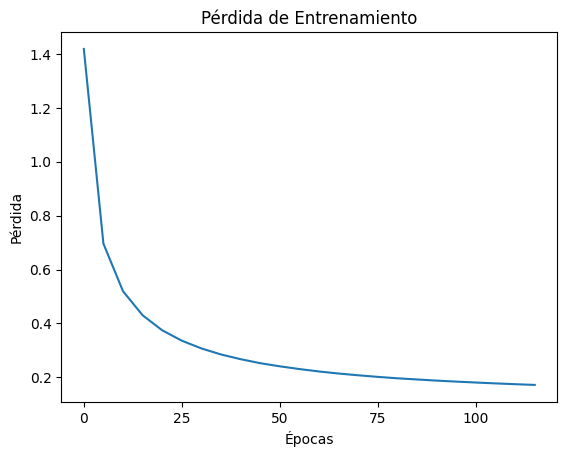

In [ ]:
import matplotlib.ticker as ticker

def plotLoss(losses):
    plt.figure()
    fig, ax = plt.subplots()
    # Graficar las pérdidas
    plt.plot(losses)
    # Configuración de los ejex x e y
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x*5):d}'))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.2))
    # Etiquetas de los ejes y título del gráfico
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Entrenamiento')
    plt.show()

# Llamar a la función con las pérdidas
plotLoss(losses)

Comente sus resultados. ¿Cómo evoluciona la loss a medida que aumenta el número de epochs?


El entrenamiento del modelo muestra una disminución significativa y constante de la loss a lo largo de las 120 épocas, indicando una mejora progresiva en la precisión del modelo. En las primeras 20 épocas, la loss disminuye rápidamente, demostrando un aprendizaje inicial efectivo. Luego, aunque la reducción de la pérdida se vuelve más gradual, el modelo sigue mejorando su capacidad de traducción. En las últimas épocas, la pérdida se estabiliza, indicando que el modelo ha alcanzado una buena precisión, mostrando que los hiperparámetros y el mecanismo de atención utilizados han permitido al modelo aprender los patrones de traducción de manera eficaz, alcanzando un buen nivel de desempeño en la tarea de traducción entre español e inglés.


Adapte las siguientes funciones para traducir oraciones con su modelo. Pruebe su traductor con algunas oraciones aleatorias del corpus.

In [ ]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
      input_tensor = sentence2tensor(input_lang, sentence)

      encoder_outputs, encoder_hidden = encoder(input_tensor)
      decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

      _, topi = decoder_outputs.topk(1)
      decoded_ids = topi.squeeze()

      decoded_words = []
      for idx in decoded_ids:
        if idx.item() == EOS_token:
          decoded_words.append('STOP')
          break
        decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluate_randomly(encoder, decoder, dataset, n=10):
    for i in range(n):
      pair = random.choice(dataset)
      print('Input:', pair[0])
      print('Traducción:', pair[1])
      output_words, _ = translate(encoder, decoder, pair[0], input_lang, output_lang)
      output_sentence = ' '.join(output_words)
      print('Predicción:', output_sentence)
      print('')

In [ ]:
encoder.eval()
decoder.eval()
evaluate_randomly(encoder, decoder, pairs, 10)

Input: recoge a tu madre
Traducción: get your mother
Predicción: your mother mother to STOP

Input: yo no era una buena madre
Traducción: i was not a good mother
Predicción: i wasn t a good mother STOP

Input: tus amigos se retrasan
Traducción: your friends are late
Predicción: your friends are late at themselves STOP

Input: tom descuidó su trabajo
Traducción: tom neglected his work
Predicción: tom neglected his work STOP

Input: creo que nos estamos atrasando en este trabajo
Traducción: i think we re getting behind in this work
Predicción: i think we re getting behind in this work STOP

Input: creo que deberíamos contratar más personas
Traducción: i think we ought to hire more people
Predicción: i think we ought to hire more people are worth

Input: tienes un sentido de orientación realmente bueno
Traducción: you have a really good sense of direction
Predicción: you have a really good sense of direction STOP

Input: yo mismo lo sé
Traducción: i know it myself
Predicción: i know it as

Comente sus resultados. ¿Qué ocurre con las cuando la traducción predicha es válida pero no igual al ground truth? ¿Qué haría para abordar este problema?

Aquí tienes una versión mejorada del texto:
  
  Las oraciones predichas con una longitud menor a 10 incluyen el token final "STOP". Los resultados de la evaluación del modelo indican que las traducciones predichas suelen acercarse a la traducción correcta, aunque a menudo contienen palabras adicionales, repeticiones o formulaciones incorrectas. Por ejemplo, en casos como la traducción "get your mother" con la predicción "your mother mother to STOP", donde se duplica la palabra "mother", o en la frase "yo mismo lo sé", traducida como "i know it myself", con la predicción "i know it as well as he knows the same", donde se añaden palabras innecesarias. Estos errores sugieren dificultades del modelo para manejar algunas estructuras de oraciones y contextos. Sin embargo, hubo casos en los que las predicciones fueron correctas, como en la frase "tienes un sentido de orientación realmente bueno", traducida como "you have a really good sense of direction", con una predicción exacta de "you have a really good sense of direction STOP".

  Para mejorar el rendimiento del modelo, se recomienda ajustar los hiperparámetros clave como la tasa de aprendizaje y el tamaño de la capa oculta. Además, considerar el uso de capas RNN bidireccionales puede ayudar a capturar mejor el contexto en ambas direcciones. La utilización de embeddings pre-entrenados, como Word2Vec, GloVe o FastText, también puede mejorar la representación de palabras y facilitar al modelo capturar significados semánticos y contextuales más precisos en las oraciones. Es fundamental aumentar y diversificar el dataset de entrenamiento para mejorar la capacidad de generalización del modelo.



### P4. Visualizando Attention (0.5 pt.)

Ahora visualizaremos los pesos de atención asignados entre las palabras traducidas. Para esto, les entregamos funciones para visualizar los pesos de atención entregados por su decoder a partir de una oración. Adapte el código al output de su modelo de ser necesario.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
%matplotlib inline

In [ ]:
def plot_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def show_attention(input_sentence):
    output_words, attentions = translate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    plot_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

Grafique la atención de las siguientes oraciones de ejemplo. Haga lo mismo con al menos tres oraciones más que puedan ser interesantes.

input = tom necesita un poco de ayuda
output = tom needs a little help STOP


<ipython-input-44-6104c59fc862>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
<ipython-input-44-6104c59fc862>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


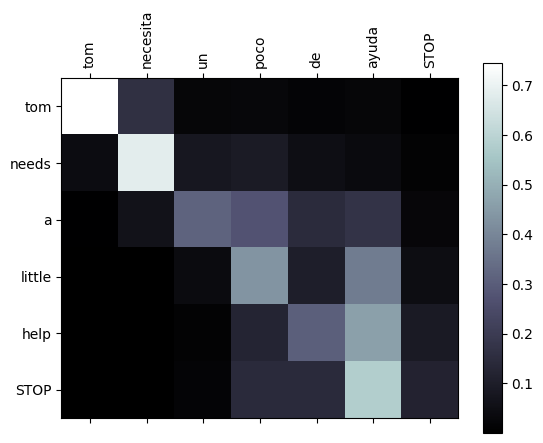

input = el perro corre rápidamente
output = the dog runs quickly quickly STOP


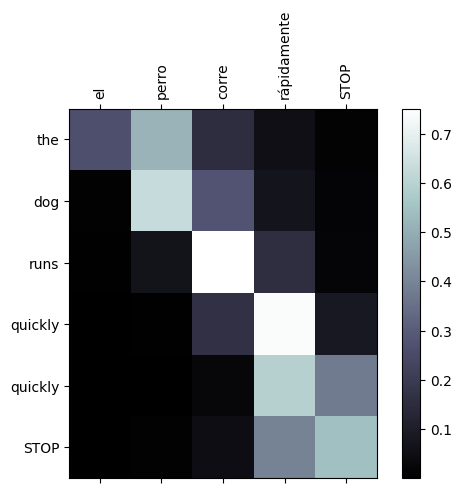

input = el banco le ofreció un alto interés
output = the bank offered him a high school girl STOP


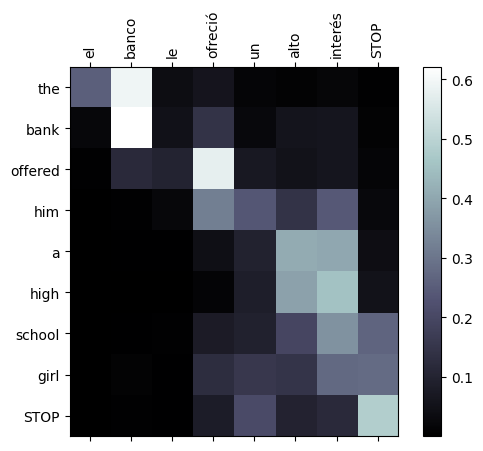

input = él toca la flauta el clarinete y el saxofón
output = he plays the flute the clarinet and the saxophone STOP


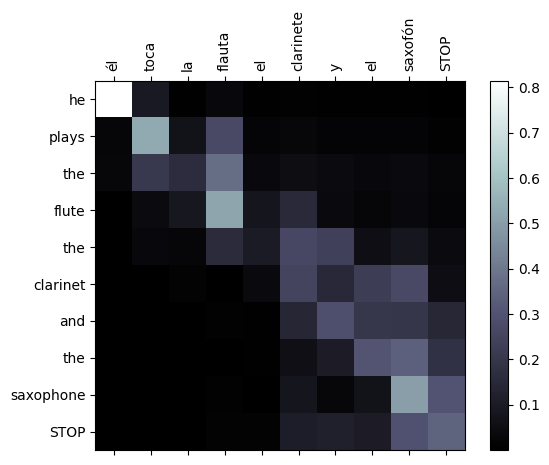

In [ ]:
## Oraciones de ejemplo

show_attention('tom necesita un poco de ayuda')

show_attention('el perro corre rápidamente')

show_attention('el banco le ofreció un alto interés')

show_attention('él toca la flauta el clarinete y el saxofón')

input = última tarea del curso !
output = i had done not lunchtime yet STOP


<ipython-input-44-6104c59fc862>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['STOP'], rotation=90)
<ipython-input-44-6104c59fc862>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


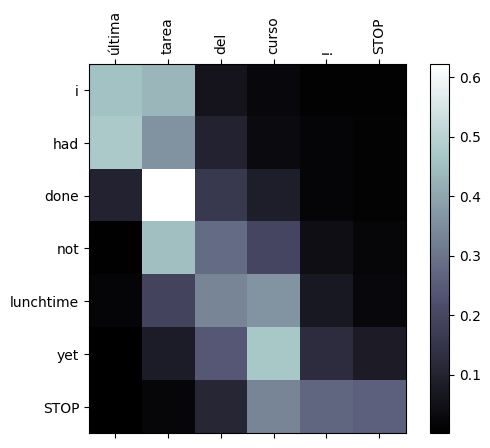

input = hola profesor
output = hello girls like a teacher STOP


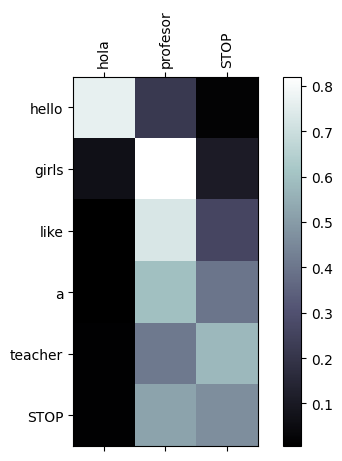

In [ ]:
## Oraciones de ejemplo

show_attention('última tarea del curso !')

show_attention('hola profesor')

# show_attention('')

Comente sus resultados. ¿Eran lo que esperaba?

El análisis de los mapas de pesos de atención generados por el modelo revela que el modelo, en general, está realizando un buen trabajo al alinear palabras de entrada con sus correspondientes traducciones en la salida. Los mapas de pesos de atención muestran que el modelo es capaz de identificar correctamente las relaciones entre la mayoría de las palabras en las oraciones de entrada y salida. Por ejemplo, en el caso de "el perro corre rápidamente" y su traducción a "the dog runs quickly", el modelo asignó la atención correctamente, aunque hubo un problema de repetición de la palabra "quickly". De manera similar, en el caso de "el banco le ofreció un alto interés", el modelo mostró una buena alineación, aunque hubo cierta confusión con el artículo "a" y el adjetivo "high".

Los resultados obtenidos son en gran medida lo esperado, aunque con algunas áreas de mejora. El modelo ha mostrado ser capaz de capturar correctamente la mayor parte de las correspondencias entre palabras y frases en las oraciones de entrada y salida. Sin embargo, los errores como la repetición de palabras indican que el modelo aún tiene espacio para mejorar.

## Parte 2: BERT

Lo primero es instalar las librerías necesarias.

In [ ]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertForNextSentencePrediction, BertForMaskedLM, BertForQuestionAnswering
import torch

Para las preguntas que siguen, utilizaremos distintas variantes de BERT disponibles en la librería transformers. [Aquí](https://huggingface.co/transformers/model_doc/bert.html) pueden encontrar toda la documentación necesaria. El modelo pre-entrenado a utilizar es "bert-base-uncased" (salvo para question answering).

BERT es un modelo de lenguaje que fue entrenado exhaustivamente sobre dos tareas: 1) Next sentence prediction. 2) Masked language modeling.

### **BertForNextSentencePrediction** (0.5 pt.)

**Pregunta 1:**  Utilizando el modelo BertForNextSentencePrediction de la librería transformers, muestre cual de las 2 oraciones es **más probable** que sea una continuación de la primera. Para esto defina la función $oracion\_mas\_probable$, que recibe el inicio de una frase, las alternativas para continuar esta frase y retorna un string indicando cual de las dos oraciones es más probable.

Por ejemplo:

Initial: "The sky is blue."\
A: "This is due to the shorter wavelength of blue light."\
B: "Chile is one of the world's greatest economies."

Debería retornar "La oración que continúa más probable es A", justificándolo con la evaluación de BERT.



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def oracion_mas_probable(first,sentA,sentB):
  #Tu implementacion
  encodingA = tokenizer(first, sentA, return_tensors='pt')
  encodingB = tokenizer(first, sentB, return_tensors='pt')
  outputA = model(**encodingA, labels=torch.LongTensor([1]))
  outputB = model(**encodingB, labels=torch.LongTensor([1]))
  logitsA = outputA.logits
  logitsB = outputB.logits

  # Calcular las probabilidades con softmax
  probsA = torch.softmax(logitsA, dim=-1)
  probsB = torch.softmax(logitsB, dim=-1)

  # Calcular la probabilidad de que las oraciones sean correctas
  probA = probsA[0, 0].item() #el item [0,0] es la probabilidad de true y [0,1] la de false según la documentacion
  probB = probsB[0, 0].item() # Prediction scores of the next sequence prediction (classification) head (scores of True/False continuation before SoftMax).

  # Comparar y devolver la oración más probable
  if probA > probB:
      return  "La oración que continúa más probable es A"
  else:
      return  "La oración que continúa más probable es B"

1.1)
Initial: "My cat is fluffy."\
A: "My dog has a curling tail."\
B: "A song can make or ruin a person’s day if they let it get to them."

In [ ]:
oracion_mas_probable("My cat is fluffy.", "My dog has a curling tail.", "A song can make or ruin a person’s day if they let it get to them.")

'La oración que continúa más probable es A'

1.2)
Initial: "The Big Apple is famous worldwide."\
A: "You can add cinnamon for the perfect combination."\
B: "It is America's largest city."

In [ ]:
oracion_mas_probable( "The Big Apple is famous worldwide.", "You can add cinnamon for the perfect combination.", "It is America's largest city.")

'La oración que continúa más probable es B'

1.3)
Initial: "Roses are red."\
A: "Violets are blue."\
B: "Fertilize them regularly for impressive flowers."

In [ ]:
oracion_mas_probable( "Roses are red.",  "Violets are blue.", "Fertilize them regularly for impressive flowers.")

'La oración que continúa más probable es A'

1.4)
Initial: "I play videogames the whole day."\
A: "They make me happy."\
B: "They make me rage."\

In [ ]:
oracion_mas_probable( "I play videogames the whole day.",  "They make me happy.", "They make me rage.")

'La oración que continúa más probable es A'

### **BertForMaskedLM** (0.5 pt.)

**Pregunta 2:**  Ahora utilizaremos BertForMaskedLM para **predecir una palabra oculta** en una oración.\
Por ejemplo:\
BERT input: "I want to _ a new car."\
BERT prediction: "buy"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
def palabra_mas_probable(sentence):
  #Tu implementacion
  tokenized_text = tokenizer.tokenize(sentence)
  masked_index = tokenized_text.index('[MASK]')
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  # print(tokenized_text)
  # print(masked_index)
  # print(indexed_tokens)
  # print(tokens_tensor)
  segments_tensors = None #Que significa esto?

  predictions = model(tokens_tensor, segments_tensors)
  predicted_index = torch.argmax(predictions[0][0][masked_index]).item()

  # Convertir el índice de vuelta a un token
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

  return predicted_token


2.1)
BERT input: "[CLS] I love [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I love [MASK] . [SEP]"
palabra_mas_probable(sent)

'you'

2.2)
BERT input: "[CLS] I hear that Karen is very [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I heard that Karen is very [MASK] . [SEP]"
palabra_mas_probable(sent)

'upset'

2.3)
BERT input: "[CLS] She had the gift of being able to [MASK] . [SEP]"

In [ ]:
sent = "[CLS] She had the gift of being able to [MASK] . [SEP]"
palabra_mas_probable(sent)

'fly'

2.4)
BERT input: "[CLS] It's not often you find a [MASK] on the street. [SEP]"

In [ ]:
sent = "[CLS] It's not often you find an [MASK] on the circus . [SEP]"
palabra_mas_probable(sent)

'expert'

### **BertForQuestionAnswering** (0.5 pt.)

**Pregunta 3**  Utilizando el modelo BertForQuestionAnswering pre-entrenado con 'bert-large-uncased-whole-word-masking-finetuned-squad', **extraiga la respuesta** a cada una de las siguientes 4 preguntas y su contexto. Recuerde cambiar el tokenizer para que coincida con el modelo.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
def entregar_respuesta(qst, cntxt):
  #Tu implementacion
  inputs = tokenizer(qst, cntxt, return_tensors='pt')
  start_positions = torch.tensor([1])
  end_positions = torch.tensor([3])#porque se eligen estas posiciones?

  outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)

  start_scores = outputs.start_logits
  end_scores = outputs.end_logits
  start_index = torch.argmax(start_scores)
  end_index = torch.argmax(end_scores)

  # Convertir los tokens de vuelta a palabras
  all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

  # Extraer las palabras y limpiar la respuesta (eliminar sub-palabras y juntar tokens)
  answer = tokenizer.convert_tokens_to_string(all_tokens[start_index:end_index+1])

  return answer

3.1)

Pregunta: "When was the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "When was the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'21 may 1879'

3.2)

Pregunta: "Who won the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "Who won the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'peruvian'

3.3)

Pregunta: "Who introduced peephole connections to LSTM networks?"
Contexto: "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."

In [ ]:
q = "Who introduced peephole connections to LSTM networks?"
c = "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."
entregar_respuesta(q, c)

'gers & schmidhuber'

3.4)

Pregunta: "When is the cat most active?"

Contexto: "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."

In [ ]:
q = "When is the cat most active?"
c = "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."
entregar_respuesta(q, c)

'dawn and dusk'